In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from zipfile import ZipFile
import re
from datetime import datetime

In [2]:
DATA_DIRS = ["/content/drive/MyDrive/yt_data", "."]
FOUND_FILES = []

In [3]:
for d in DATA_DIRS:
    if not os.path.isdir(d):
        continue
    for pattern in ["channel_data.*", "video_data.*", "comments/comment*.csv", "comments/comment*.json"]:
        FOUND_FILES.extend(glob.glob(os.path.join(d, pattern)))

In [4]:
FOUND_FILES = sorted(set(FOUND_FILES))
print("Found files:", FOUND_FILES)

Found files: ['/content/drive/MyDrive/yt_data/channel_data.json', '/content/drive/MyDrive/yt_data/comments/comment1.csv', '/content/drive/MyDrive/yt_data/comments/comment2.csv', '/content/drive/MyDrive/yt_data/comments/comment3.csv', '/content/drive/MyDrive/yt_data/comments/comment4.csv', '/content/drive/MyDrive/yt_data/comments/comment5.csv', '/content/drive/MyDrive/yt_data/video_data.json']


In [5]:
# Helper to load data
channels = None
videos = None
comments = None

In [6]:
# --- Load channels ---
channels = None
chan_candidates = [f for f in FOUND_FILES if os.path.basename(f).lower().startswith(("channel_data","channels_data"))]
if chan_candidates:
    p = chan_candidates[0]
    print("Loading channels from", p)
    try:
        # Try reading as JSON array / object
        channels = pd.read_json(p, lines=False)
    except ValueError:
        try:
            # Try JSON lines
            channels = pd.read_json(p, lines=True)
        except Exception as e:
            print("Failed to read JSON normally:", e)
            # as fallback, try pandas read_csv (if misnamed)
            try:
                channels = pd.read_csv(p)
            except Exception as e2:
                print("Fallback read_csv failed:", e2)
    if channels is not None:
        print("Channels rows:", len(channels))
else:
    print("No channels file found.")

Loading channels from /content/drive/MyDrive/yt_data/channel_data.json
Channels rows: 1561


In [7]:
# --- Load videos ---
videos = None
vid_candidates = [f for f in FOUND_FILES if os.path.basename(f).lower().startswith(("video_data","videos_data"))]
if vid_candidates:
    p = vid_candidates[0]
    print("Loading videos from", p)
    try:
        videos = pd.read_json(p, lines=False)
    except ValueError:
        try:
            videos = pd.read_json(p, lines=True)
        except Exception as e:
            print("Failed to read video JSON normally:", e)
            try:
                videos = pd.read_csv(p)
            except Exception as e2:
                print("Fallback read_csv failed:", e2)
    if videos is not None:
        print("Videos rows:", len(videos))
else:
    print("No videos file found.")

Loading videos from /content/drive/MyDrive/yt_data/video_data.json
Videos rows: 440772


In [8]:
# --- Load comments ---
comment_paths = sorted([f for f in FOUND_FILES if os.path.basename(f).lower().startswith("comment") or "/comments/" in f.lower()])
comments = None
if comment_paths:
    print("Loading comments from", comment_paths)
    comment_dfs = []
    for p in comment_paths:
        try:
            df = pd.read_csv(p, low_memory=False)
            comment_dfs.append(df)
            print(f"Loaded {len(df)} rows from {p}")
        except Exception as e:
            print("Failed to read", p, ":", e)
    if comment_dfs:
        comments = pd.concat(comment_dfs, ignore_index=True)
        print("Total comments rows:", len(comments))
else:
    print("No comment files found.")

Loading comments from ['/content/drive/MyDrive/yt_data/comments/comment1.csv', '/content/drive/MyDrive/yt_data/comments/comment2.csv', '/content/drive/MyDrive/yt_data/comments/comment3.csv', '/content/drive/MyDrive/yt_data/comments/comment4.csv', '/content/drive/MyDrive/yt_data/comments/comment5.csv']
Loaded 1413653 rows from /content/drive/MyDrive/yt_data/comments/comment1.csv
Loaded 832041 rows from /content/drive/MyDrive/yt_data/comments/comment2.csv
Loaded 1116331 rows from /content/drive/MyDrive/yt_data/comments/comment3.csv
Loaded 1539237 rows from /content/drive/MyDrive/yt_data/comments/comment4.csv
Loaded 1038920 rows from /content/drive/MyDrive/yt_data/comments/comment5.csv
Total comments rows: 5940182


## EDA - Channels, Videos and Comments

In [9]:
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

datasets = {
    'Channels': channels,
    'Videos': videos,
    'Comments': comments
}

for name, df in datasets.items():
    if df is not None:
        print(f"\n{name} Dataset:")
        print(f"  Rows: {df.shape[0]:,}")
        print(f"  Columns: {df.shape[1]}")
        print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET OVERVIEW

Channels Dataset:
  Rows: 1,561
  Columns: 11
  Memory Usage: 1.63 MB

Videos Dataset:
  Rows: 440,772
  Columns: 13
  Memory Usage: 1006.56 MB

Comments Dataset:
  Rows: 5,940,182
  Columns: 13
  Memory Usage: 3974.57 MB


In [11]:
print("CHANNELS DATA - COLUMN INFORMATION")
print("=" * 80)
print(channels.info())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = channels.isnull().sum()
missing_pct = (missing / len(channels)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

CHANNELS DATA - COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   channel_id          1561 non-null   object             
 1   channel_title       1561 non-null   object             
 2   description         1294 non-null   object             
 3   custom_url          1552 non-null   object             
 4   created_at          1561 non-null   datetime64[ns, UTC]
 5   thumbnail           1561 non-null   object             
 6   country             1561 non-null   object             
 7   view_count          1561 non-null   int64              
 8   subscriber_count    1561 non-null   int64              
 9   hidden_subscribers  1561 non-null   object             
 10  video_count         1561 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage:

In [12]:
print("CHANNELS DATA - SAMPLE ROWS")
print("=" * 80)
channels.head(10)

CHANNELS DATA - SAMPLE ROWS


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14 07:12:04+00:00,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26 09:33:39+00:00,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28 20:45:20+00:00,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11 03:18:17+00:00,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22 17:10:07.380790+00:00,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139
5,UCr-FJP6W-XeTsUXP1MZ57Tw,Enganchate Rock,¡Bienvenides a nuestro canal! \n\nPor acá vas ...,@enganchaterock,2020-04-18 07:27:03.280320+00:00,https://yt3.ggpht.com/UZ147iLPmWxxwLyLaZMzg4H7...,AR,288621,1780,false,1362
6,UCqZfd-NCxLmhacxgbJRsX3g,Yair EL SUPREMO OFFICIAL,El Capitán De Los Recuentros,@yairelsupremoofficial6140,2018-05-22 01:52:35+00:00,https://yt3.ggpht.com/UzyB_Blb-N8XW7hicapd1rkn...,AR,17062,171,false,264
7,UCn8AIEPEb8fFyKTR-rHLvgQ,Saturday Not Alive,It’s Saturday NOT Alive!\n\nThe NUMBER ONE aud...,@saturdaynotalive,2022-01-27 04:41:37.387500+00:00,https://yt3.ggpht.com/zCh71jU-TCQPI3pQabn4scht...,AR,145281,5330,false,267
8,UCsgbhyDFNNRN61eudIgalHg,#en-señas-SILVINAVHELBER,Taller básico de LENGUA DE SEÑAS ARGENTINA.\nE...,@en-senas-silvinavhelber,2021-09-19 16:18:58.056358+00:00,https://yt3.ggpht.com/UfFp0mLuFuIRefOTDhQwuoku...,AR,165541,2200,false,103
9,UCPr0HEFKN8wtDIfcPsVB10Q,Telefe Rosario,None,@teleferosario4216,2019-03-11 22:47:18+00:00,https://yt3.ggpht.com/ytc/AGIKgqOjeRpkRVvq619I...,AR,15751609,45700,false,12213


In [13]:
print("CHANNELS DATA - STATISTICAL SUMMARY")
print("=" * 80)
channels.describe(include='all').T

CHANNELS DATA - STATISTICAL SUMMARY


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
channel_id,1561,1561,UCAdFp0UVS0CcjRzgIvlykPg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_title,1561,1561,Don John,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1294,1291,\n,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
custom_url,1552,1552,@donjohn7715,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,1561,NaN,NaN,NaN,2016-08-06 04:49:22.653610496+00:00,2005-09-22 15:12:34+00:00,2013-06-26 21:27:45+00:00,2017-03-28 23:20:34+00:00,2020-06-07 10:27:44.965146112+00:00,2022-10-26 07:43:19.033214+00:00,NaN
thumbnail,1561,1561,https://yt3.ggpht.com/ytc/AGIKgqOTEI1_FGqslC61...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1561,82,nan,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view_count,1561.0,NaN,NaN,NaN,97929325.748238,0.0,6675.0,76309.0,1267678.0,29270768662.0,1032451395.160133
subscriber_count,1561.0,NaN,NaN,NaN,315607.128764,0.0,138.0,1090.0,12200.0,75000000.0,2648774.914767
hidden_subscribers,1561,1,false,1561,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Numeric columns in channels: ['view_count', 'subscriber_count', 'video_count']


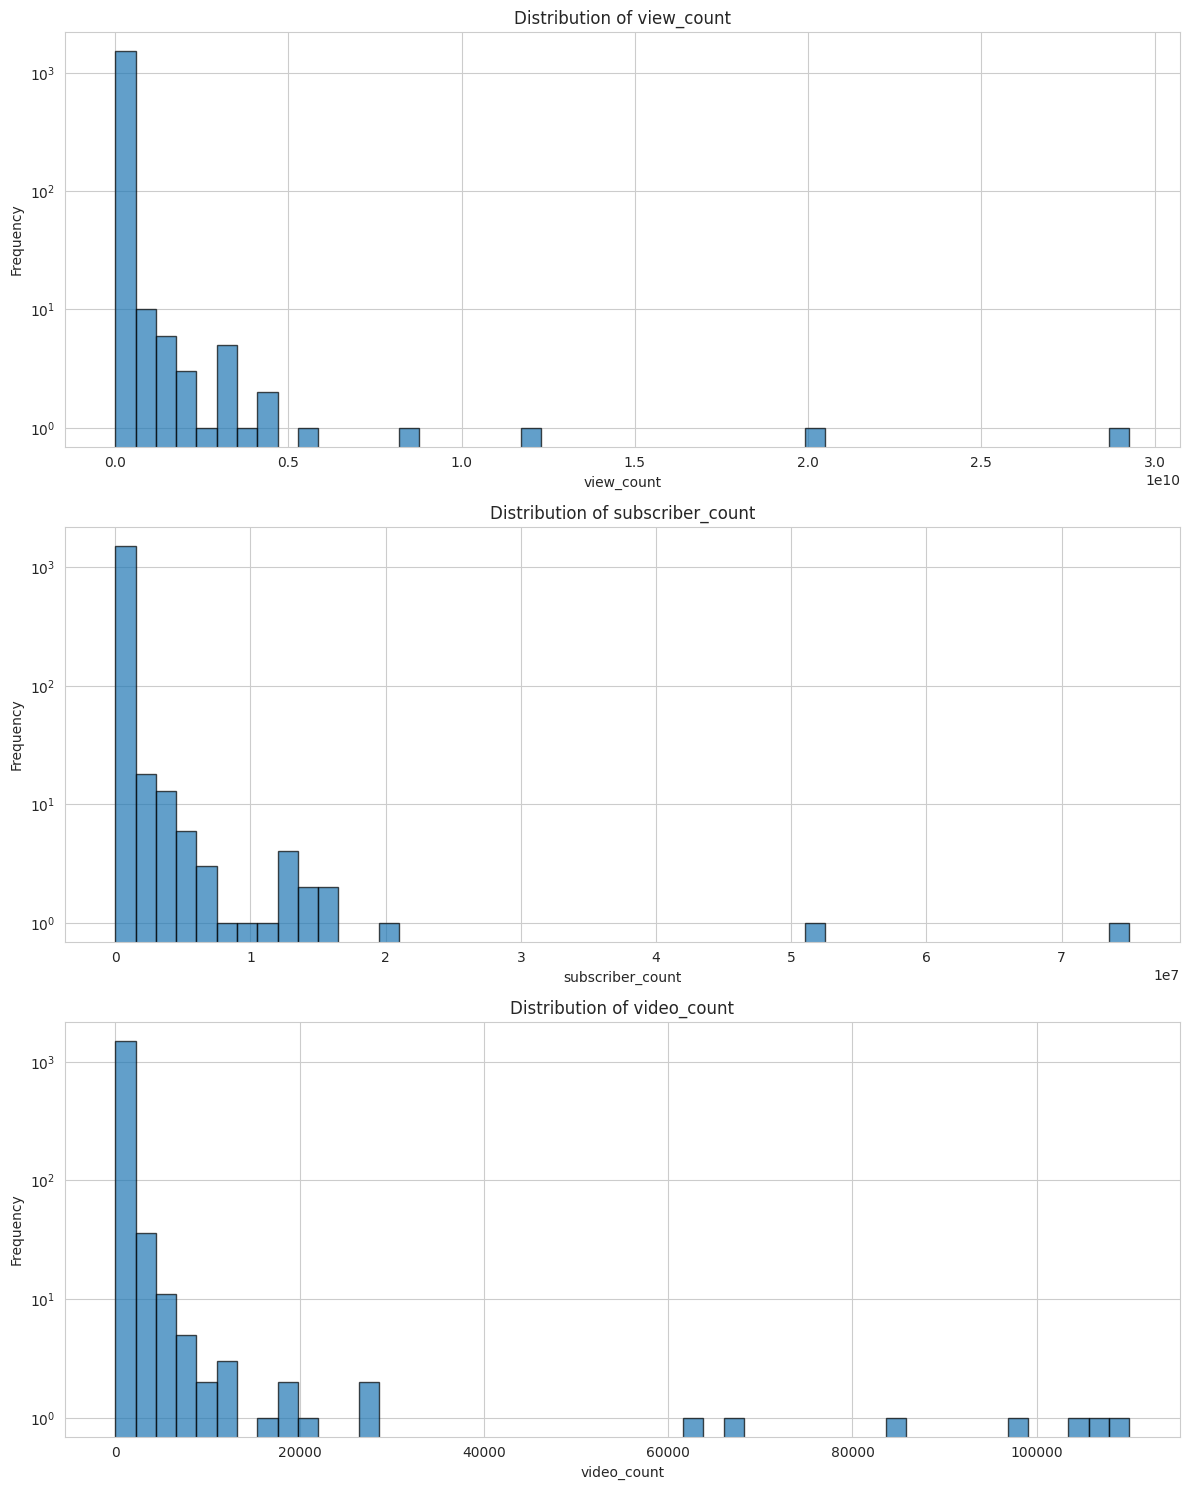

In [14]:
# Check for numeric columns in channels
numeric_cols = channels.select_dtypes(include=[np.number]).columns.tolist()

if numeric_cols:
    print(f"Numeric columns in channels: {numeric_cols}")

    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 5*len(numeric_cols)))
    if len(numeric_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(numeric_cols):
        axes[idx].hist(channels[col].dropna(), bins=50, edgecolor='black', alpha=0.7, log=True)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found in channels data")

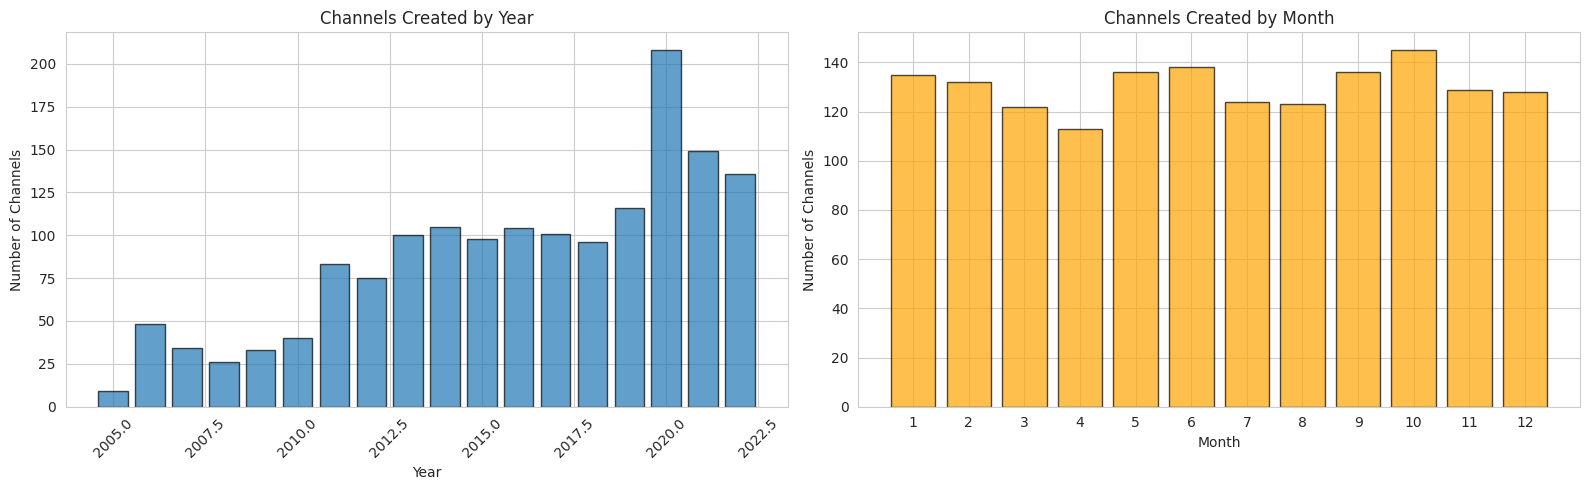

In [15]:
if 'created_at' in channels.columns:
    # Ensure created_at is datetime
    channels['created_at'] = pd.to_datetime(channels['created_at'], errors='coerce')

    # Extract temporal features
    channels['created_year'] = channels['created_at'].dt.year.astype('Int64')  # integer type
    channels['created_month'] = channels['created_at'].dt.month
    channels['created_day_of_week'] = channels['created_at'].dt.day_name()

    # Channels created per year
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # By year
    year_counts = channels['created_year'].value_counts().sort_index()
    axes[0].bar(year_counts.index.astype(int), year_counts.values, edgecolor='black', alpha=0.7)
    axes[0].set_title('Channels Created by Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Channels')
    axes[0].tick_params(axis='x', rotation=45)

    # By month
    month_counts = channels['created_month'].value_counts().sort_index()
    axes[1].bar(month_counts.index, month_counts.values, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_title('Channels Created by Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Number of Channels')
    axes[1].set_xticks(range(1, 13))

    plt.tight_layout()
    plt.show()

In [16]:
print("VIDEOS DATA - COLUMN INFORMATION")
print("=" * 80)
print(videos.info())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = videos.isnull().sum()
missing_pct = (missing / len(videos)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

VIDEOS DATA - COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440772 entries, 0 to 440771
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   channel_id      440772 non-null  object             
 1   channel_title   440754 non-null  object             
 2   video_id        440772 non-null  object             
 3   category_id     440772 non-null  int64              
 4   published_at    440772 non-null  datetime64[ns, UTC]
 5   title           440772 non-null  object             
 6   description     412826 non-null  object             
 7   thumbnail       440772 non-null  object             
 8   view_count      440266 non-null  float64            
 9   like_count      431637 non-null  float64            
 10  favorite_count  440772 non-null  int64              
 11  comment_count   424799 non-null  float64            
 12  tags            329136 non-null  object

In [17]:
print("VIDEOS DATA - SAMPLE ROWS")
print("=" * 80)
videos.head(10)

VIDEOS DATA - SAMPLE ROWS


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."
5,UCuPivVjnfNo4mb3Oog_frZg,A24,ALNV4mdHGEE,1,2022-09-13 12:59:00+00:00,MaXXXine | Official Promo HD | A24,SUBSCRIBE: http://bit.ly/A24subscribe\n\nFrom ...,https://i.ytimg.com/vi/ALNV4mdHGEE/default.jpg,1533054.0,47886.0,0,1951.0,"a24,a24 films,a24 trailers,independent films,t..."
6,UCuPivVjnfNo4mb3Oog_frZg,A24,y8lFgF_IjPw,1,2018-03-14 13:00:05+00:00,Eighth Grade | Official Trailer HD | A24,SUBSCRIBE: http://bit.ly/A24subscribe\n\nFrom ...,https://i.ytimg.com/vi/y8lFgF_IjPw/default.jpg,7981883.0,85956.0,0,8592.0,"a24,a24 films,a24 trailers,independent films,t..."
7,UCuPivVjnfNo4mb3Oog_frZg,A24,wxN1T1uxQ2g,1,2021-12-14 13:57:38+00:00,Everything Everywhere All At Once | Official T...,SUBSCRIBE: http://bit.ly/A24subscribe\r\n\r\nA...,https://i.ytimg.com/vi/wxN1T1uxQ2g/default.jpg,31669490.0,403022.0,0,17531.0,"a24,a24 films,a24 trailers,independent films,t..."
8,UCuPivVjnfNo4mb3Oog_frZg,A24,L5PW5r3pEOg,1,2022-07-26 13:00:12+00:00,Pearl | Official Trailer HD | A24,SUBSCRIBE: http://bit.ly/A24subscribe\n\nFrom ...,https://i.ytimg.com/vi/L5PW5r3pEOg/default.jpg,9093806.0,136033.0,0,5982.0,"a24,a24 films,a24 trailers,independent films,t..."
9,UC9dGqMAPJRpA7M0oSdgtQgg,BFI,k1ybZ-lMvMI,1,2022-09-12 17:53:45+00:00,GETTING IT BACK: THE STORY OF CYMANDE trailer ...,A riveting documentary about the British Black...,https://i.ytimg.com/vi/k1ybZ-lMvMI/default.jpg,2597.0,74.0,0,0.0,"British Film Institute (Publisher),British,fil..."


In [18]:
# Convert published_at to datetime
if 'published_at' in videos.columns:
    videos['published_at'] = pd.to_datetime(videos['published_at'], errors='coerce')
    print(f"✓ Converted published_at to datetime")
    print(f"Date range: {videos['published_at'].min()} to {videos['published_at'].max()}")

✓ Converted published_at to datetime
Date range: 2005-07-08 14:39:22+00:00 to 2023-09-21 18:57:37+00:00


In [20]:
import json

In [21]:
# --- Load category mapping from JSON ---
with open('/content/drive/MyDrive/yt_data/video_categories.json', 'r') as f:
    category_data = json.load(f)

# Build a dictionary mapping ID → Category Title
category_mapping = {
    int(item['id']): item['snippet']['title']
    for item in category_data['items']
}

VIDEO CATEGORY DISTRIBUTION
category_name
News & Politics          89052
Music                    84805
People & Blogs           79242
Entertainment            54724
Education                35187
Gaming                   16079
Science & Technology     15767
Film & Animation         12690
Nonprofits & Activism    10950
Howto & Style             9713
Sports                    9334
Comedy                    9221
Travel & Events           6492
Autos & Vehicles          3861
Pets & Animals            3554
Movies                      68
Trailers                    26
Shows                        7
Name: count, dtype: int64


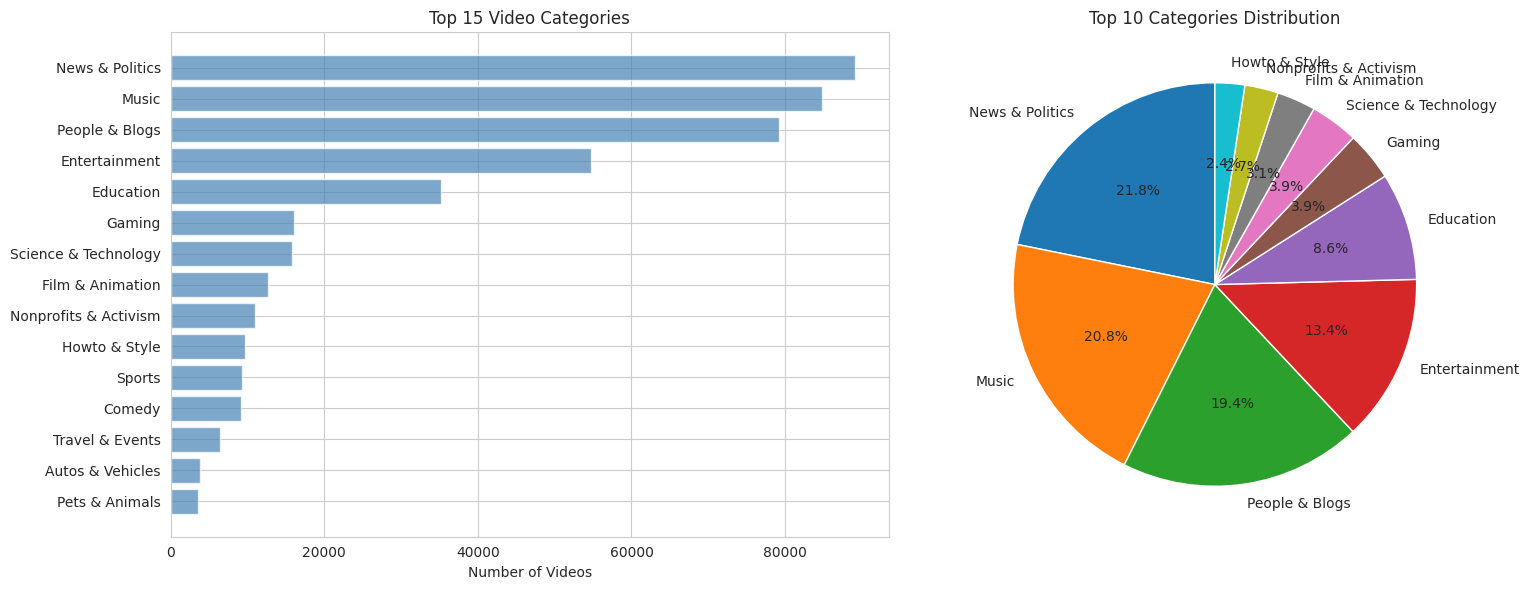

In [22]:
if 'category_id' in videos.columns:
    print("VIDEO CATEGORY DISTRIBUTION")
    print("=" * 80)

    # Ensure category_id is numeric (to match mapping keys)
    videos['category_id'] = pd.to_numeric(videos['category_id'], errors='coerce')
    videos['category_name'] = videos['category_id'].map(category_mapping)

    # Handle unknown categories
    videos['category_name'].fillna('Unknown', inplace=True)

    category_counts = videos['category_name'].value_counts()
    print(category_counts.head(20))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Top 15 categories (bar chart)
    top_cats = category_counts.head(15)
    axes[0].barh(range(len(top_cats)), top_cats.values, color='steelblue', alpha=0.7)
    axes[0].set_yticks(range(len(top_cats)))
    axes[0].set_yticklabels(top_cats.index)
    axes[0].set_xlabel('Number of Videos')
    axes[0].set_title('Top 15 Video Categories')
    axes[0].invert_yaxis()

    # Pie chart of top 10
    top10_cats = category_counts.head(10)
    axes[1].pie(top10_cats.values, labels=top10_cats.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Top 10 Categories Distribution')

    plt.tight_layout()
    plt.show()

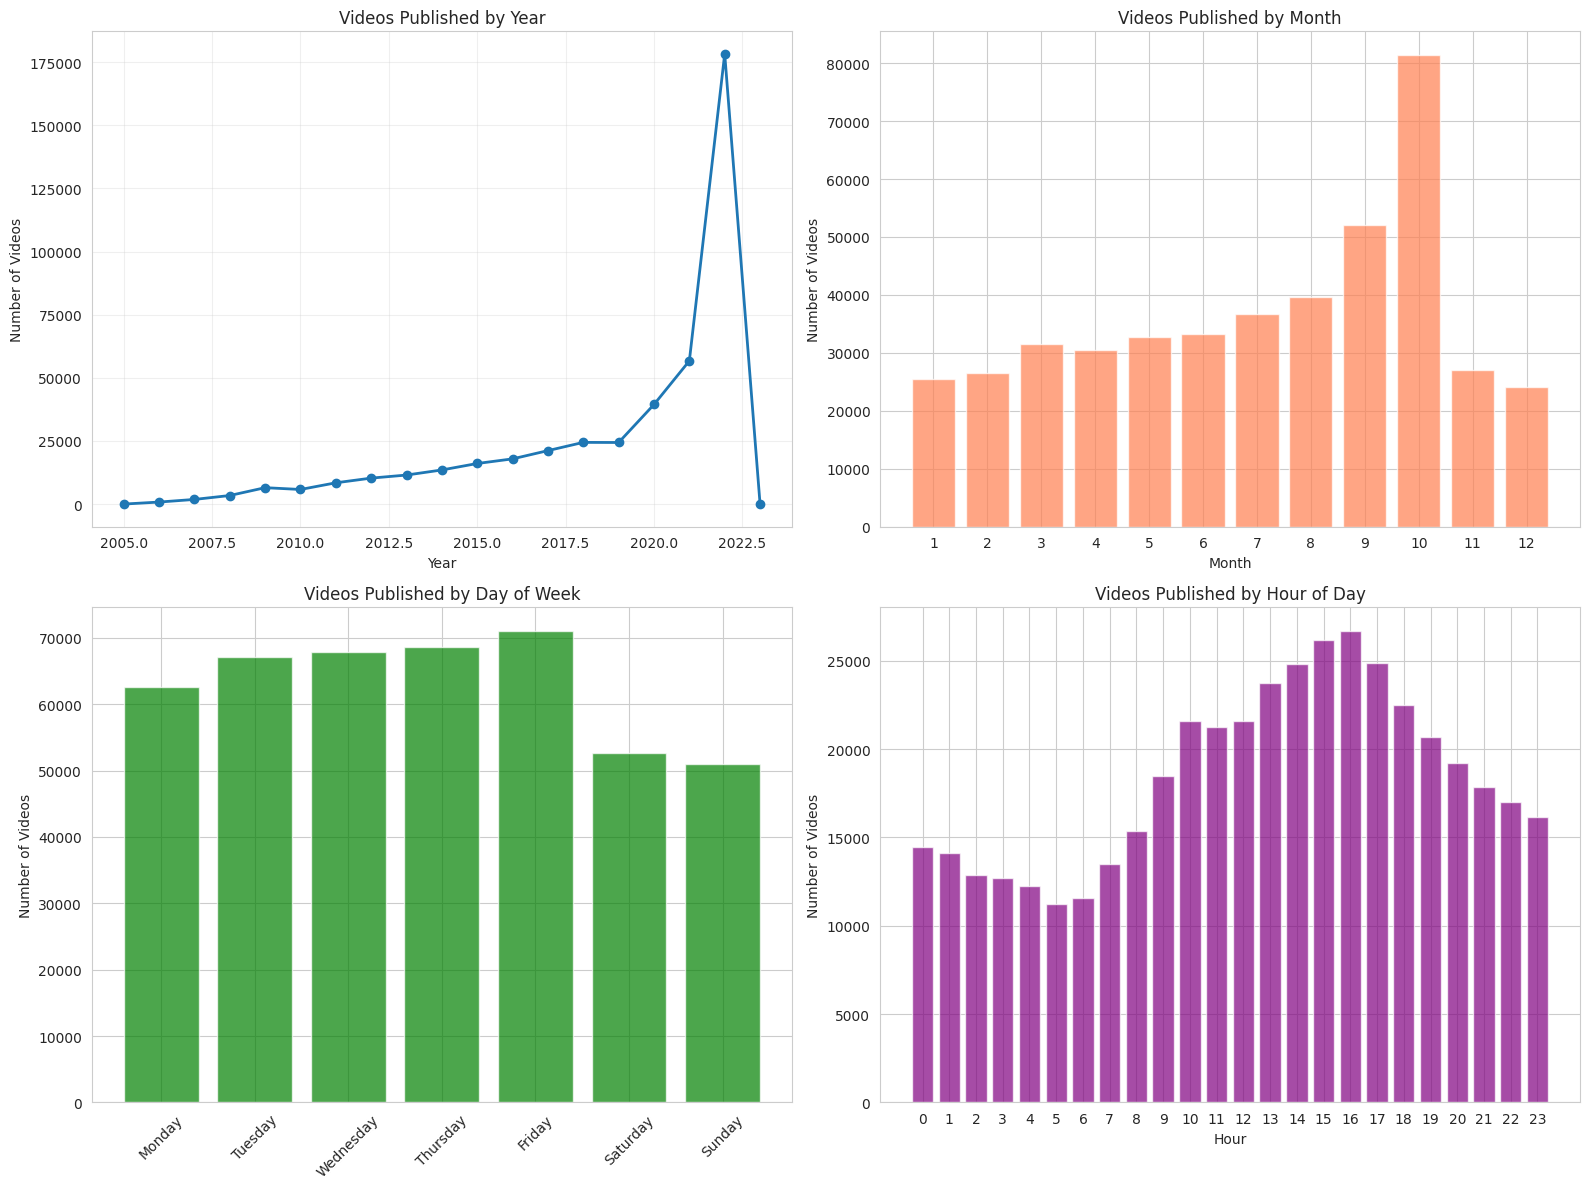

In [23]:
if 'published_at' in videos.columns:
    # Extract temporal features
    videos['published_year'] = videos['published_at'].dt.year
    videos['published_month'] = videos['published_at'].dt.month
    videos['published_day_of_week'] = videos['published_at'].dt.day_name()
    videos['published_hour'] = videos['published_at'].dt.hour

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Videos per year
    year_counts = videos['published_year'].value_counts().sort_index()
    axes[0, 0].plot(year_counts.index, year_counts.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Videos Published by Year')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Videos')
    axes[0, 0].grid(True, alpha=0.3)

    # Videos per month
    month_counts = videos['published_month'].value_counts().sort_index()
    axes[0, 1].bar(month_counts.index, month_counts.values, color='coral', alpha=0.7)
    axes[0, 1].set_title('Videos Published by Month')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Number of Videos')
    axes[0, 1].set_xticks(range(1, 13))

    # Videos per day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = videos['published_day_of_week'].value_counts()
    day_counts = day_counts.reindex(day_order, fill_value=0)
    axes[1, 0].bar(range(len(day_counts)), day_counts.values, color='green', alpha=0.7)
    axes[1, 0].set_xticks(range(len(day_counts)))
    axes[1, 0].set_xticklabels(day_counts.index, rotation=45)
    axes[1, 0].set_title('Videos Published by Day of Week')
    axes[1, 0].set_ylabel('Number of Videos')

    # Videos per hour
    hour_counts = videos['published_hour'].value_counts().sort_index()
    axes[1, 1].bar(hour_counts.index, hour_counts.values, color='purple', alpha=0.7)
    axes[1, 1].set_title('Videos Published by Hour of Day')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel('Number of Videos')
    axes[1, 1].set_xticks(range(0, 24))

    plt.tight_layout()
    plt.show()

VIDEOS PER CHANNEL ANALYSIS
Total unique channels in videos: 175385

Top 20 channels by video count:
                    channel_name  video_count
94473   UCXIJgqnII2ZOINSWNOGFThA         1373
12178   UC3M7l8ved_rYQ45AVzS0RGA          696
68984   UCO0akufu9MOzyz3nvGIXAAw          687
103648  UC_gUM8rL-Lrg6O3adPW9K1g          602
148112  UCpwvZwUam-URkxB7g4USKpg          556
161498  UCupvZG-5ko_eiXAupbDfxWw          529
154970  UCsT0YIqwnpJCM-mx7-gSA4Q          451
105983  UCaXkIU1QidjPwiAYu6GcHjg          408
68864   UCNye-wNBqNL5ZzHSJj3l8Bg          404
123125  UCgrNz-aDmcr2uuto8_DL2jg          358
43339   UCEaVmwN4wR6pJs3VAnpZe8g          320
33461   UCB1u_wJThc3_e5J4VVj7hQQ          297
73149   UCPWXiRWZ29zrxPFIQT7eHSA          296
5445    UC0vn8ISa4LKMunLbzaXLnOQ          291
119618  UCf_HItERkRB3vnkWt2RSOLg          287
143782  UCoMdktPbSTixAyNGwb-UYkQ          286
37646   UCCXoCcu9Rp7NPbTzIvogpZg          286
13072   UC3gNmTGu-TTbFPpfSs5kNkg          286
120956  UCg40OxZ1GYh3u3jB

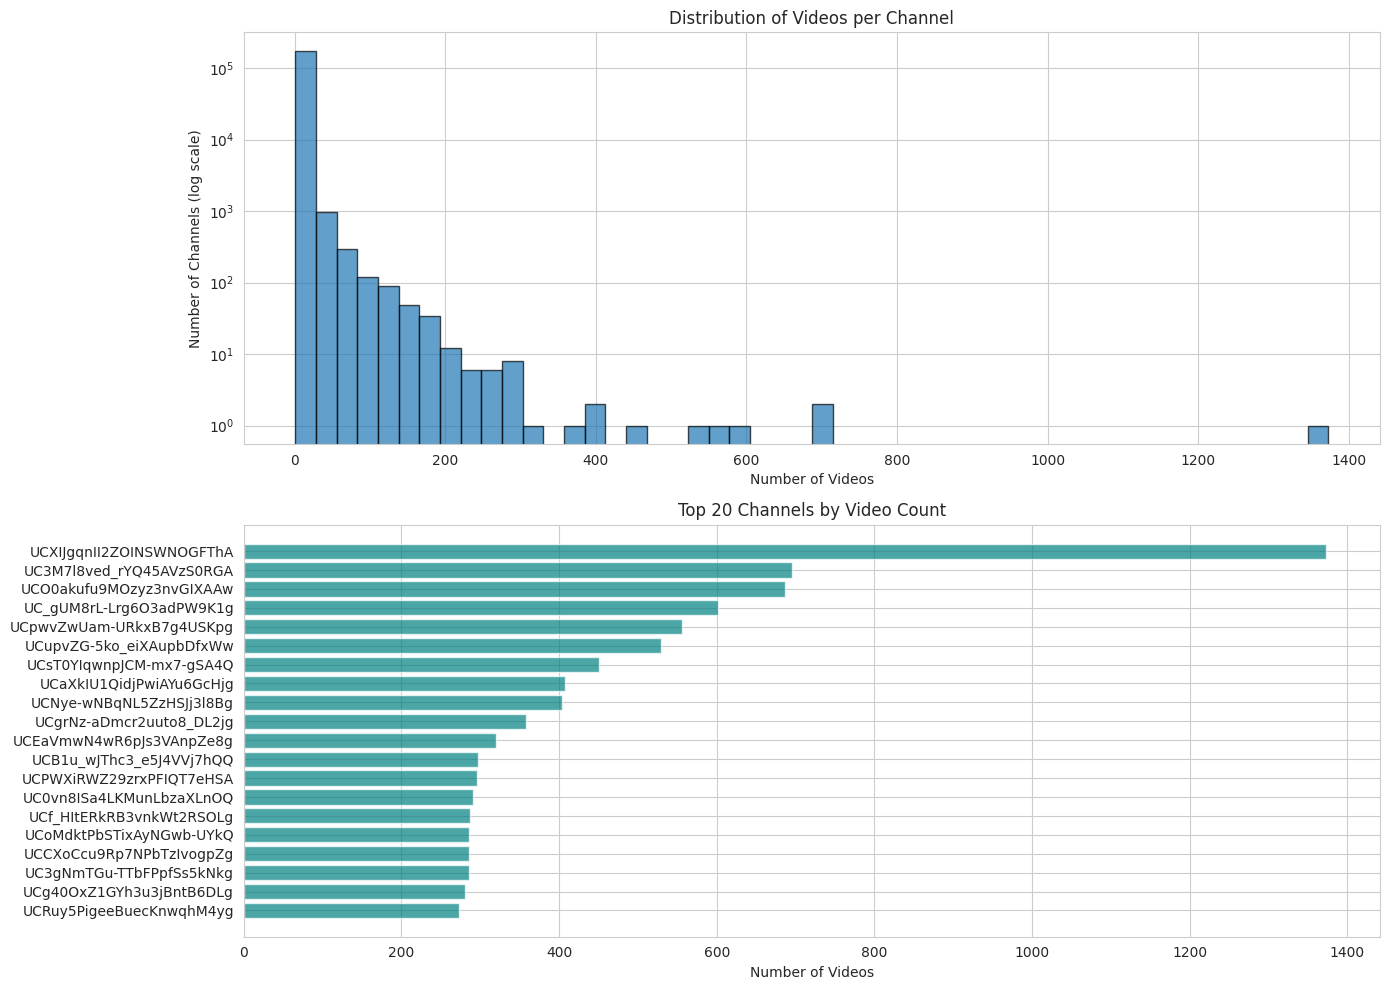


Videos per Channel Statistics:
count    175385.000000
mean          2.513168
std           9.210852
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1373.000000
Name: video_count, dtype: float64


In [24]:
print("VIDEOS PER CHANNEL ANALYSIS")
print("=" * 80)

# --- Compute videos per channel ---
videos_per_channel = (
    videos.groupby('channel_id')
    .size()
    .reset_index(name='video_count')
    .sort_values('video_count', ascending=False)
)

# --- Merge with channels to get channel names ---
if 'channel_id' in channels.columns and 'channel_name' in channels.columns:
    videos_per_channel = videos_per_channel.merge(
        channels[['channel_id', 'channel_name']],
        on='channel_id',
        how='left'
    )
else:
    videos_per_channel['channel_name'] = videos_per_channel['channel_id']  # fallback

# --- Summary stats ---
print(f"Total unique channels in videos: {videos_per_channel['channel_id'].nunique()}")
print(f"\nTop 20 channels by video count:")
print(videos_per_channel.head(20)[['channel_name', 'video_count']])

# --- Visualization ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10))  # two rows, one column

# Histogram (log scale on y-axis)
axes[0].hist(videos_per_channel['video_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Videos per Channel')
axes[0].set_xlabel('Number of Videos')
axes[0].set_ylabel('Number of Channels (log scale)')
axes[0].set_yscale('log')

# Top 20 channels (barh)
top20 = videos_per_channel.head(20)
axes[1].barh(top20['channel_name'], top20['video_count'], color='teal', alpha=0.7)
axes[1].set_xlabel('Number of Videos')
axes[1].set_title('Top 20 Channels by Video Count')
axes[1].invert_yaxis()  # largest on top

plt.tight_layout()
plt.show()

# --- Statistics ---
print(f"\nVideos per Channel Statistics:")
print(videos_per_channel['video_count'].describe())

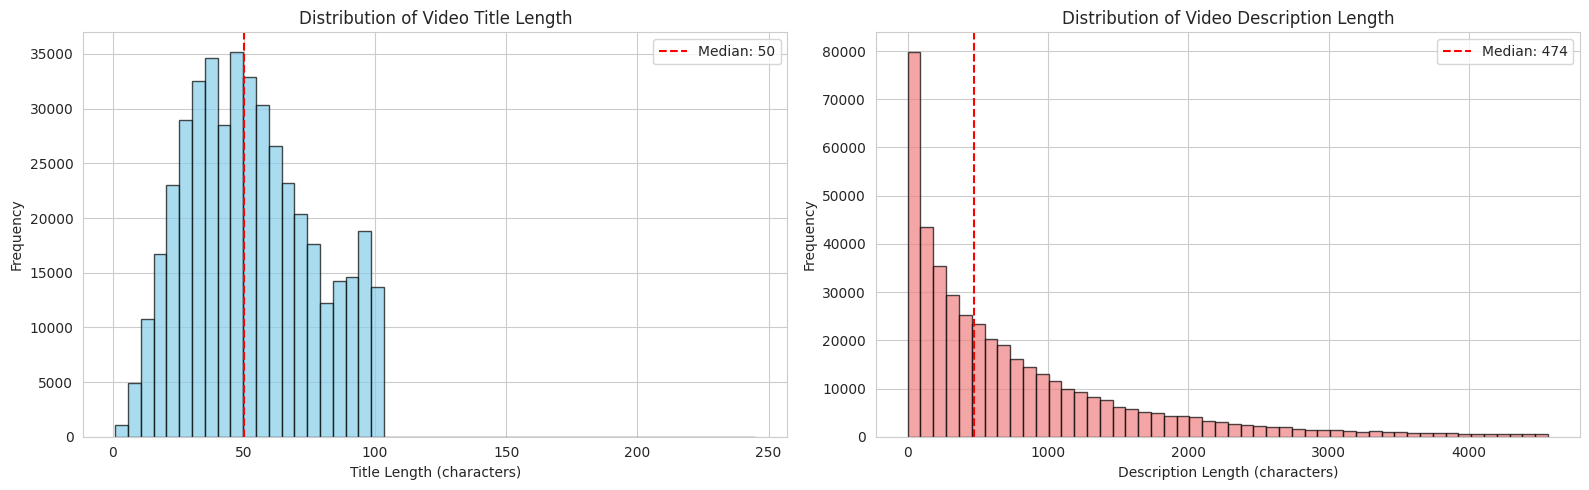

Title Length Statistics:
count    440772.000000
mean         52.786890
std          23.820052
min           1.000000
25%          34.000000
50%          50.000000
75%          70.000000
max         245.000000
Name: title_length, dtype: float64

Description Length Statistics:
count    440772.000000
mean        799.784292
std         930.204551
min           0.000000
25%         154.000000
50%         482.000000
75%        1090.000000
max        5012.000000
Name: description_length, dtype: float64


In [25]:
if 'title' in videos.columns:
    videos['title_length'] = videos['title'].fillna('').astype(str).str.len()

if 'description' in videos.columns:
    videos['description_length'] = videos['description'].fillna('').astype(str).str.len()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

if 'title_length' in videos.columns:
    axes[0].hist(videos['title_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_title('Distribution of Video Title Length')
    axes[0].set_xlabel('Title Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(videos['title_length'].median(), color='red', linestyle='--', label=f'Median: {videos["title_length"].median():.0f}')
    axes[0].legend()

if 'description_length' in videos.columns:
    # Remove extreme outliers for better visualization
    desc_data = videos['description_length'][videos['description_length'] < videos['description_length'].quantile(0.99)]
    axes[1].hist(desc_data, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[1].set_title('Distribution of Video Description Length')
    axes[1].set_xlabel('Description Length (characters)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(desc_data.median(), color='red', linestyle='--', label=f'Median: {desc_data.median():.0f}')
    axes[1].legend()

plt.tight_layout()
plt.show()

print("Title Length Statistics:")
if 'title_length' in videos.columns:
    print(videos['title_length'].describe())

print("\nDescription Length Statistics:")
if 'description_length' in videos.columns:
    print(videos['description_length'].describe())

In [26]:
print("COMMENTS DATA - COLUMN INFORMATION")
print("=" * 80)
print(comments.info())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = comments.isnull().sum()
missing_pct = (missing / len(comments)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

COMMENTS DATA - COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940182 entries, 0 to 5940181
Data columns (total 13 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   video_id           object
 1   comment_id         object
 2   parent_id          object
 3   comment_text       object
 4   author_name        object
 5   author_channel_id  object
 6   author_url         object
 7   published_at       object
 8   can_rate           bool  
 9   can_reply          bool  
 10  like_count         int64 
 11  reply_count        int64 
 12  is_public          bool  
dtypes: bool(3), int64(2), object(8)
memory usage: 470.2+ MB
None

MISSING VALUES
                   Missing Count  Percentage
parent_id                4970439   83.674860
comment_text                 756    0.012727
author_name                   79    0.001330
author_url                    79    0.001330
author_channel_id             79    0.001330


In [27]:
print("COMMENTS DATA - SAMPLE ROWS")
print("=" * 80)
comments.head(10)

COMMENTS DATA - SAMPLE ROWS


,video_id,comment_id,parent_id,comment_text,author_name,author_channel_id,author_url,published_at,can_rate,can_reply,like_count,reply_count,is_public
0,_zBhtFFkUDI,UgxeYo0-MMQQHfg9Red4AaABAg.8wsZ2d33UJ-9WXoa6zVYes,UgxeYo0-MMQQHfg9Red4AaABAg,I believe it resets you to 0,@GrahamWhatmough,UCJAbstgijk_gmkjV8mUv3dA,http://www.youtube.com/channel/UCJAbstgijk_gmk...,2021-12-29T12:48:13Z,True,False,12,0,True
1,b01GZoiYjaQ,Ugz_343-IxqQpxkPnql4AaABAg.9XchlzLgbjv9Xcka6bJV6z,Ugz_343-IxqQpxkPnql4AaABAg,The Donietsk &amp; Lugansl People&#39;s Repúb...,@mariaangelicabrunellsolar7086,UCiClJzQdNQeAqcrfDXNbrxg,http://www.youtube.com/channel/UCiClJzQdNQeAqc...,2022-01-25T16:40:06Z,True,False,8,0,True
2,cyHqXQRtNOE,Ugzv10b6wGEDtG6MTdt4AaABAg.9fHHgXtAqCn9fIYKmb6RzC,Ugzv10b6wGEDtG6MTdt4AaABAg,that ain’t no damn panic attack 😂 those are cr...,@cryjng549,UCw0SZln-5RMABfwH7uwy54A,http://www.youtube.com/channel/UCw0SZln-5RMABf...,2022-08-29T03:42:46Z,True,False,14,0,True
3,xjVZSfhS2QA,Ugxt9xZzkF5Jz8B0Exh4AaABAg.9_35Sa1lp_79_36FU9OvvM,Ugxt9xZzkF5Jz8B0Exh4AaABAg,@@flossietaylor6239 Please who is your financi...,@nuggets9113,UC4mbqL87SjY81CAbsI8zaow,http://www.youtube.com/channel/UC4mbqL87SjY81C...,2022-03-27T00:40:24Z,True,False,10,0,True
4,QQVSHuNFC_A,Ugx3a2fgbYkcd5Esl1x4AaABAg.9hhcVCVattK9hhfEpDn7hC,Ugx3a2fgbYkcd5Esl1x4AaABAg,@@letsgobrandon9867 The more you troll these v...,@imcallingjapan2178,UC3EqH1tdXsQPVODMjeEUBUg,http://www.youtube.com/channel/UC3EqH1tdXsQPVO...,2022-10-28T00:14:54Z,True,False,14,0,True
5,Y9Hcgf4q8yw,UgyphMgOdhMkTX8cvLV4AaABAg.9Safa5NADJK9bV0Jp5FNbY,UgyphMgOdhMkTX8cvLV4AaABAg,知育玩具になんて曲入れてんだｗ,@syrup-_-9858,UCFBVMTrCccoqQnZoVdjHHFA,http://www.youtube.com/channel/UCFBVMTrCccoqQn...,2022-05-26T13:50:05Z,True,False,36,0,True
6,_th2keiChs4,UghSU6lukYnJp3gCoAEC.7z3P4TOZ29J7-HGs7zeXOR,UghSU6lukYnJp3gCoAEC,Finite Atticus He would make a better emperor.,@rainy7106,UCNbh2zMb7s9u4_U8o9hi72g,http://www.youtube.com/channel/UCNbh2zMb7s9u4_...,2015-04-18T00:25:16Z,True,False,17,0,True
7,Eh6_uRSn4wg,UgxDG2g7_XlWaJbzrtp4AaABAg.9hgvyiG-4-z9j8X7LWhYB_,UgxDG2g7_XlWaJbzrtp4AaABAg,Es que lo de ellos nunca fue amor...,@aryrios4165,UCiwszC0P-ZzmczBMKKK61_A,http://www.youtube.com/channel/UCiwszC0P-Zzmcz...,2022-12-02T16:25:22Z,True,False,9,0,True
8,Eh6_uRSn4wg,UgxS_NdtTr-5tc1SJVB4AaABAg.9_u45Uh-Ysd9aYR_p_cP5a,UgxS_NdtTr-5tc1SJVB4AaABAg,@@JoyPi244 todavía es una actriz joven; tiene...,@nanny2120,UCZaNnfnGvY8ndJZS3yqI11Q,http://www.youtube.com/channel/UCZaNnfnGvY8ndJ...,2022-05-03T01:14:40Z,True,False,33,0,True
9,7siSUMdLKgM,UgyCXByGMkuHPO6tszZ4AaABAg.9QDKSLJz6W49QcHcqmJZHU,UgyCXByGMkuHPO6tszZ4AaABAg,@@dim358 Многие восхищаются монтажом и сведени...,@Aisenshpits,UCWlo3epW1TrimCrwIdyyJig,http://www.youtube.com/channel/UCWlo3epW1TrimC...,2021-08-04T12:38:34Z,True,False,36,0,True


In [28]:
print("COMMENTS ANALYSIS")
print("=" * 80)

print(f"Total comments: {len(comments):,}")
print(f"Unique videos with comments: {comments['video_id'].nunique():,}")
print(f"Unique comment IDs: {comments['comment_id'].nunique():,}")

# Comments per video
comments_per_video = comments.groupby('video_id').size().reset_index(name='comment_count')
print(f"\nComments per Video Statistics:")
print(comments_per_video['comment_count'].describe())

COMMENTS ANALYSIS
Total comments: 5,940,182
Unique videos with comments: 2,694
Unique comment IDs: 5,938,888

Comments per Video Statistics:
count      2694.000000
mean       2204.967335
std       11956.169453
min           1.000000
25%          18.000000
50%         160.500000
75%        1040.500000
max      469187.000000
Name: comment_count, dtype: float64


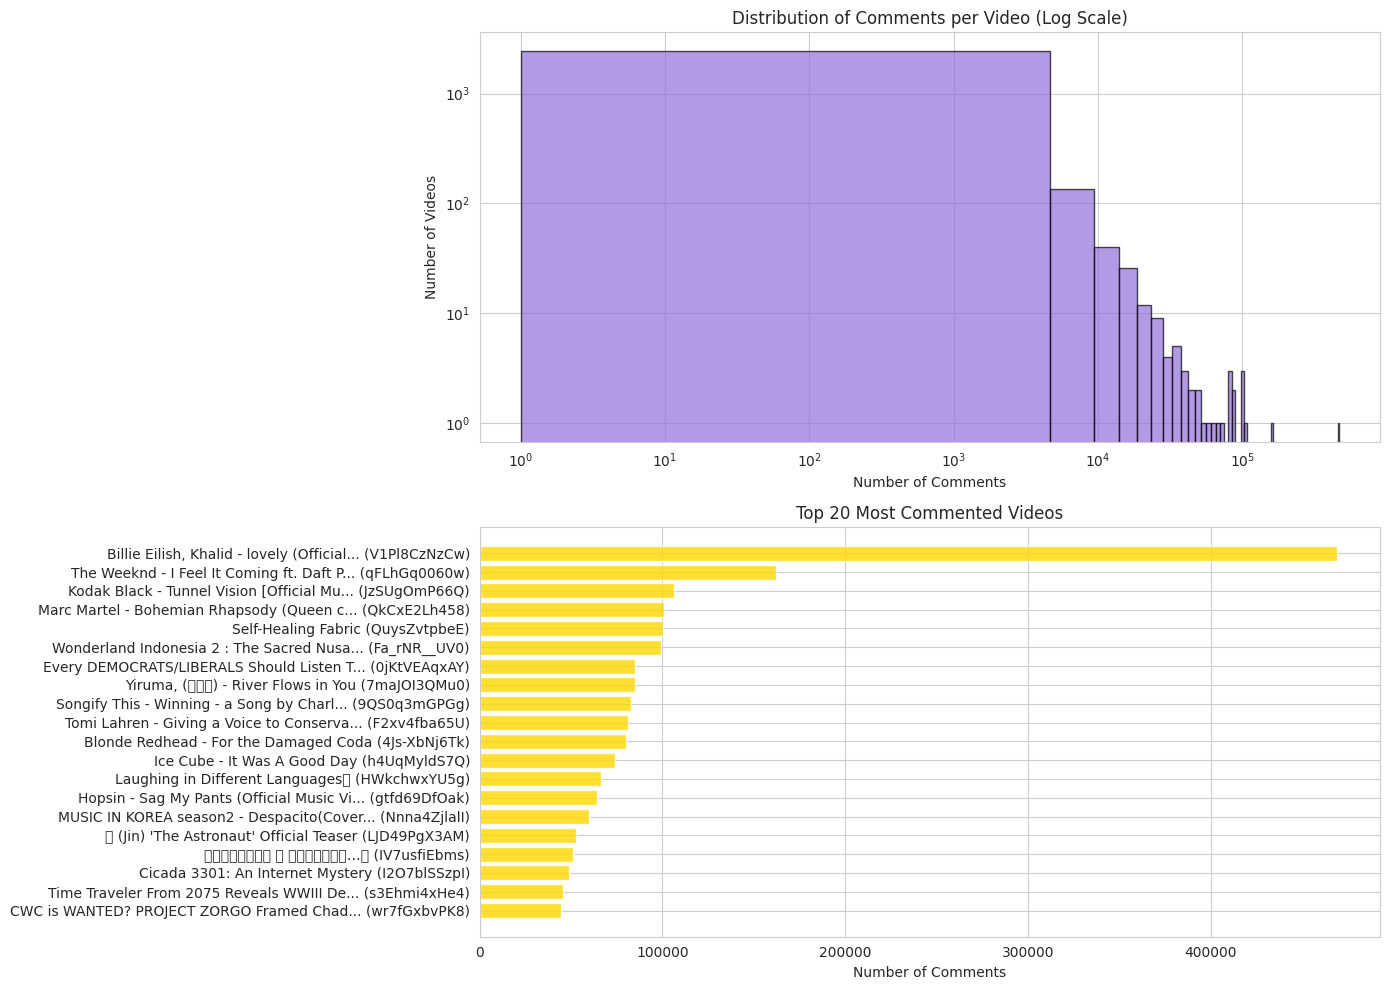

In [29]:
# --- Comments per video distribution ---
comments_per_video = (
    comments.groupby('video_id')
    .size()
    .reset_index(name='comment_count')
    .sort_values('comment_count', ascending=False)
)

# --- Merge with videos to get video titles ---
if 'video_id' in videos.columns and 'title' in videos.columns:
    comments_per_video = comments_per_video.merge(
        videos[['video_id', 'title']],
        on='video_id',
        how='left'
    )
else:
    comments_per_video['title'] = comments_per_video['video_id']  # fallback if missing

# --- Plot vertically (2 rows, 1 column) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Histogram (log-log scale)
axes[0].hist(
    comments_per_video['comment_count'],
    bins=100,
    edgecolor='black',
    alpha=0.7,
    color='mediumpurple'
)
axes[0].set_title('Distribution of Comments per Video (Log Scale)')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Number of Videos')
axes[0].set_yscale('log')
axes[0].set_xscale('log')

# --- Top 20 most commented videos ---
top20_commented = comments_per_video.head(20).copy()

# Create combined label: title + video_id (shortened if too long)
top20_commented['label'] = top20_commented.apply(
    lambda x: f"{x['title'][:40]}... ({x['video_id']})" if len(x['title']) > 40 else f"{x['title']} ({x['video_id']})",
    axis=1
)

axes[1].barh(
    top20_commented['label'],
    top20_commented['comment_count'],
    color='gold',
    alpha=0.8
)
axes[1].set_xlabel('Number of Comments')
axes[1].set_title('Top 20 Most Commented Videos')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

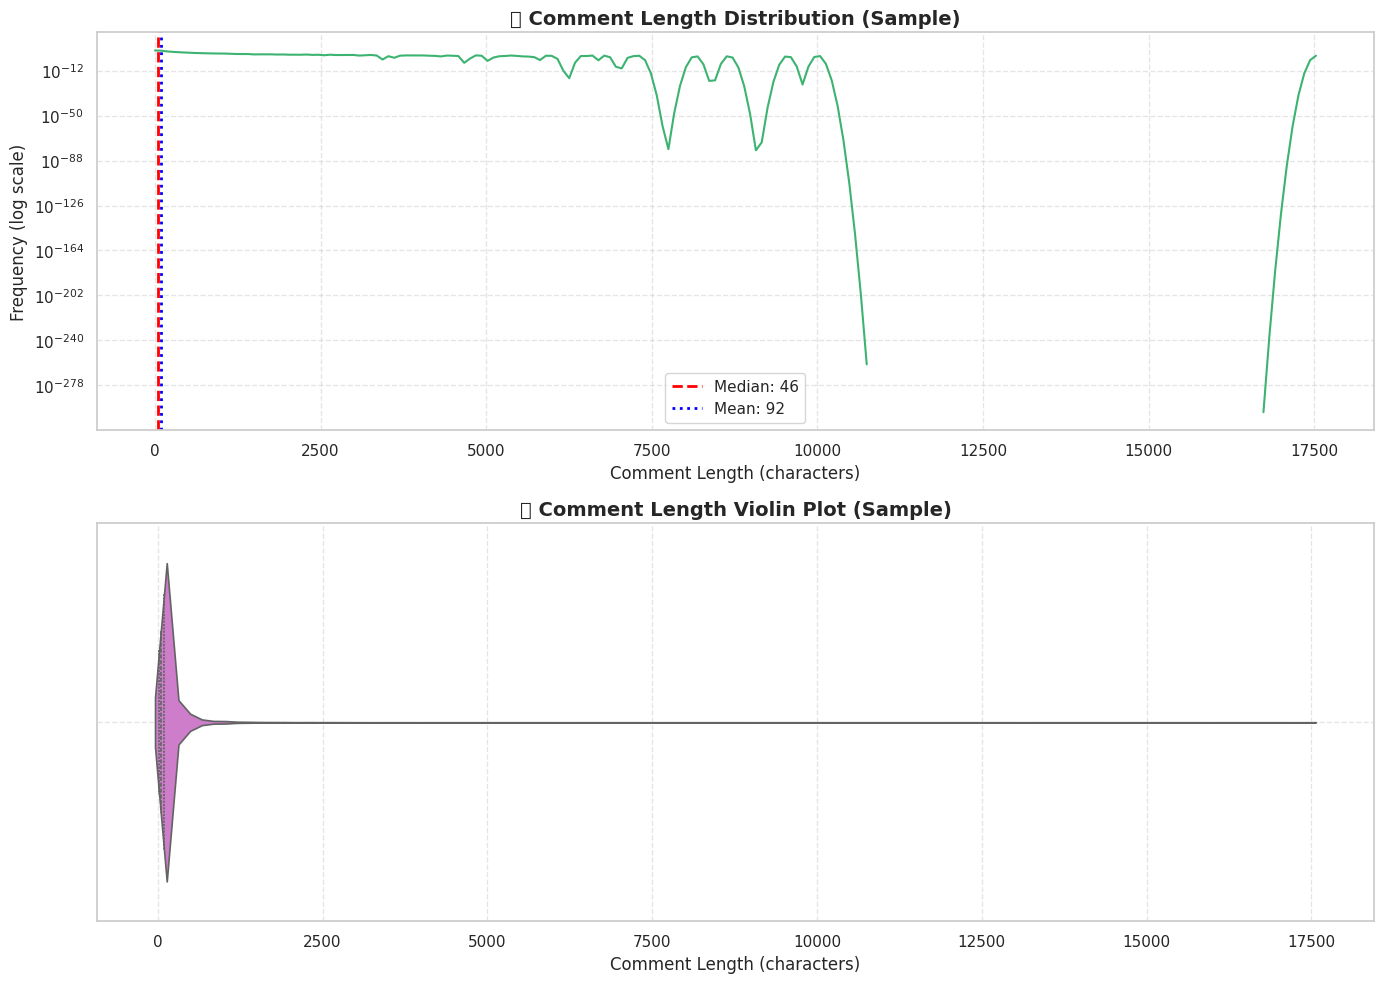

Comment Length Statistics (Sample):
count    100000.000000
mean         92.099640
std         212.861098
min           1.000000
25%          21.000000
50%          46.000000
75%          95.000000
max       17527.000000
Name: comment_text, dtype: float64


In [30]:
if 'comment_text' in comments.columns:
    # Sample for performance
    comment_sample = comments['comment_text'].dropna().sample(min(100000, len(comments)), random_state=42)
    comment_lengths = comment_sample.astype(str).str.len()

    # Calculate stats
    median_len = comment_lengths.median()
    mean_len = comment_lengths.mean()

    # Set visual style
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # --- Histogram with KDE ---
    sns.histplot(
        comment_lengths, bins=100, kde=True, color='mediumseagreen', alpha=0.7, ax=axes[0],
        log_scale=(False, True)  # y-axis log scale to show skewed data better
    )
    axes[0].axvline(median_len, color='red', linestyle='--', linewidth=2, label=f'Median: {median_len:.0f}')
    axes[0].axvline(mean_len, color='blue', linestyle=':', linewidth=2, label=f'Mean: {mean_len:.0f}')
    axes[0].set_title('📝 Comment Length Distribution (Sample)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Comment Length (characters)')
    axes[0].set_ylabel('Frequency (log scale)')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # --- Violin Plot (shows density + outliers) ---
    sns.violinplot(
        x=comment_lengths, color='orchid', linewidth=1.2, inner='quartile', ax=axes[1]
    )
    axes[1].set_title('🎻 Comment Length Violin Plot (Sample)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Comment Length (characters)')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    print("Comment Length Statistics (Sample):")
    print(comment_lengths.describe())

COMMENT TYPES
Original comments: 4,970,439 (83.67%)
Replies: 969,743 (16.33%)


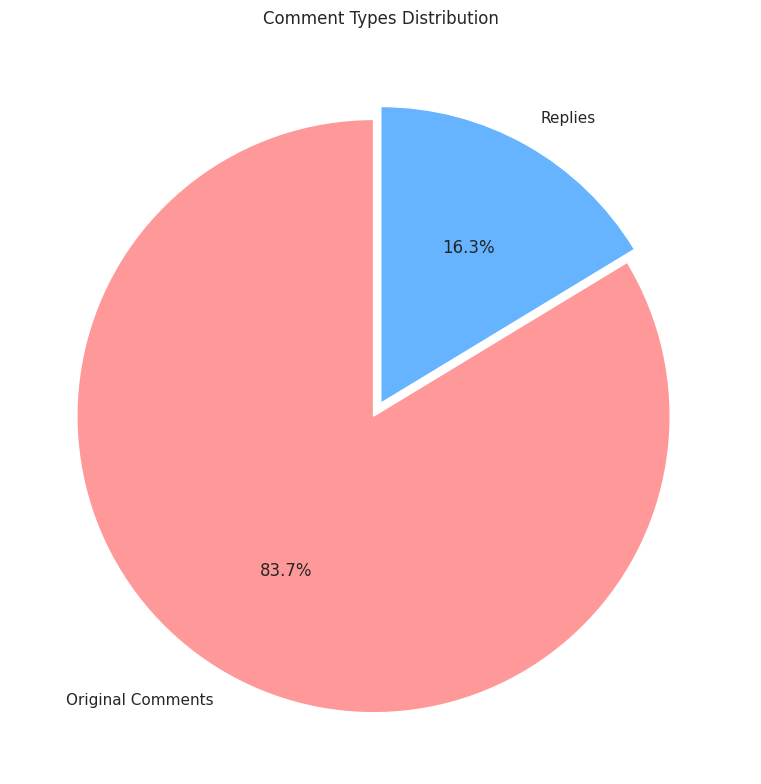

In [31]:
if 'parent_id' in comments.columns:
    # Identify replies vs original comments
    is_reply = comments['parent_id'].notna()

    print("COMMENT TYPES")
    print("=" * 80)
    print(f"Original comments: {(~is_reply).sum():,} ({(~is_reply).mean()*100:.2f}%)")
    print(f"Replies: {is_reply.sum():,} ({is_reply.mean()*100:.2f}%)")

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 8))
    sizes = [(~is_reply).sum(), is_reply.sum()]
    labels = ['Original Comments', 'Replies']
    colors = ['#ff9999', '#66b3ff']
    explode = (0.05, 0)

    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
    ax.set_title('Comment Types Distribution')
    plt.tight_layout()
    plt.show()

In [32]:
# Merge videos with channels to get channel info
if channels is not None and videos is not None:
    videos_with_channels = videos.merge(
        channels[['channel_id', 'channel_title']],
        on='channel_id',
        how='left',
        suffixes=('_video', '_channel')
    )

    print("MERGED VIDEOS WITH CHANNELS")
    print("=" * 80)
    print(f"Videos successfully merged: {videos_with_channels['channel_title_channel'].notna().sum():,} / {len(videos_with_channels):,}")
    print(f"\nSample of merged data:")
    print(videos_with_channels[['video_id', 'title', 'channel_title_channel']].head(10))

MERGED VIDEOS WITH CHANNELS
Videos successfully merged: 11,909 / 440,772

Sample of merged data:
      video_id                                              title  \
0  3niQ1dJcqFg                             Los Angeles street art   
1  51b-1WotLww        Los Angeles street art  # graffiti # bomber   
2  jd2B6rH--tg                               The infinite bicycle   
3  TRGHIN2PGIA  Christian Bale Breaks Down His Most Iconic Cha...   
4  VqDRhf1UpvE                                  Smart Card (2005)   
5  ALNV4mdHGEE                 MaXXXine | Official Promo HD | A24   
6  y8lFgF_IjPw           Eighth Grade | Official Trailer HD | A24   
7  wxN1T1uxQ2g  Everything Everywhere All At Once | Official T...   
8  L5PW5r3pEOg                  Pearl | Official Trailer HD | A24   
9  k1ybZ-lMvMI  GETTING IT BACK: THE STORY OF CYMANDE trailer ...   

  channel_title_channel  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4            

In [33]:
# Get video information for comments
if videos is not None and comments is not None:
    comments_with_videos = comments.merge(
        videos[['video_id', 'title', 'channel_id']],
        on='video_id',
        how='left'
    )

    print("MERGED COMMENTS WITH VIDEOS")
    print("=" * 80)
    print(f"Comments successfully merged: {comments_with_videos['title'].notna().sum():,} / {len(comments_with_videos):,}")

    # Most commented videos
    print("\nTop 10 Most Commented Videos:")
    most_commented = comments_with_videos.groupby(['video_id', 'title']).size().reset_index(name='comment_count')
    most_commented = most_commented.sort_values('comment_count', ascending=False).head(10)
    print(most_commented)

MERGED COMMENTS WITH VIDEOS
Comments successfully merged: 5,940,182 / 5,940,182

Top 10 Most Commented Videos:
         video_id                                              title  \
1375  V1Pl8CzNzCw  Billie Eilish, Khalid - lovely (Official Music...   
2307  qFLhGq0060w  The Weeknd - I Feel It Coming ft. Daft Punk (O...   
883   JzSUgOmP66Q  Kodak Black - Tunnel Vision [Official Music Vi...   
1179  QkCxE2Lh458      Marc Martel - Bohemian Rhapsody (Queen cover)   
1187  QuysZvtpbeE                                Self-Healing Fabric   
684   Fa_rNR__UV0  Wonderland Indonesia 2 : The Sacred Nusantara ...   
65    0jKtVEAqxAY     Every DEMOCRATS/LIBERALS Should Listen To this   
379   7maJOI3QMu0                 Yiruma, (이루마) - River Flows in You   
443   9QS0q3mGPGg   Songify This - Winning - a Song by Charlie Sheen   
661   F2xv4fba65U  Tomi Lahren - Giving a Voice to Conservative A...   

      comment_count  
1375         469187  
2307         161919  
883          106279  
1179    

In [34]:
print("=" * 80)
print("OVERALL DATASET SUMMARY")
print("=" * 80)

summary_stats = {
    'Metric': [],
    'Value': []
}

# Channels
if channels is not None:
    summary_stats['Metric'].append('Total Channels')
    summary_stats['Value'].append(f"{len(channels):,}")

# Videos
if videos is not None:
    summary_stats['Metric'].extend([
        'Total Videos',
        'Unique Channels (in videos)',
        'Avg Videos per Channel'
    ])
    summary_stats['Value'].extend([
        f"{len(videos):,}",
        f"{videos['channel_id'].nunique():,}",
        f"{len(videos) / videos['channel_id'].nunique():.2f}"
    ])

# Comments
if comments is not None:
    summary_stats['Metric'].extend([
        'Total Comments',
        'Unique Videos (with comments)',
        'Avg Comments per Video'
    ])
    summary_stats['Value'].extend([
        f"{len(comments):,}",
        f"{comments['video_id'].nunique():,}",
        f"{len(comments) / comments['video_id'].nunique():.2f}"
    ])

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

OVERALL DATASET SUMMARY
                       Metric     Value
               Total Channels     1,561
                 Total Videos   440,772
  Unique Channels (in videos)   175,385
       Avg Videos per Channel      2.51
               Total Comments 5,940,182
Unique Videos (with comments)     2,694
       Avg Comments per Video   2204.97


In [35]:
print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)

for name, df in [('Channels', channels), ('Videos', videos), ('Comments', comments)]:
    if df is not None:
        print(f"\n{name}:")
        print(f"  Total rows: {len(df):,}")
        print(f"  Duplicate rows: {df.duplicated().sum():,}")
        print(f"  Columns with missing data: {(df.isnull().sum() > 0).sum()}")
        print(f"  Total missing values: {df.isnull().sum().sum():,}")
        print(f"  Missing data percentage: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

DATA QUALITY REPORT

Channels:
  Total rows: 1,561
  Duplicate rows: 0
  Columns with missing data: 2
  Total missing values: 276
  Missing data percentage: 1.26%

Videos:
  Total rows: 440,772
  Duplicate rows: 0
  Columns with missing data: 6
  Total missing values: 165,214
  Missing data percentage: 1.87%

Comments:
  Total rows: 5,940,182
  Duplicate rows: 1,294
  Columns with missing data: 5
  Total missing values: 4,971,432
  Missing data percentage: 6.44%
